In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bittu1203","key":"5d8f44055e7210894e5669566592b4c4"}'}

In [ ]:
import os

# Create the Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json into the directory
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permissions so Kaggle won't complain
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d badasstechie/celebahq-resized-256x256


Dataset URL: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256
License(s): GPL-2.0
 88% 248M/283M [00:00<00:00, 718MB/s] 
100% 283M/283M [00:00<00:00, 764MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("celebahq-resized-256x256.zip", 'r') as zip_ref:
    zip_ref.extractall("celebahq")

# Now you can access the files inside the "celebahq" folder


In [ ]:
cd celebahq/


/content/celebahq


### **Using the Image Corruption Module to degrade the images**

**We have used model corruption modules like gaussian noise, motion blur, occlusion, jpeg compression and then randomly degraded the images**

In [ ]:
import os
import cv2
import numpy as np
import random
from PIL import Image
from tqdm import tqdm

def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_img = image.astype(np.float32) + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

def add_motion_blur(image, kernel_size=15):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred

def add_occlusion(image, num_blocks=5):
    h, w, _ = image.shape
    for _ in range(num_blocks):
        x = random.randint(0, w - 50)
        y = random.randint(0, h - 50)
        bw = random.randint(20, 50)
        bh = random.randint(20, 50)
        image[y:y+bh, x:x+bw] = random.randint(0, 255)
    return image

def jpeg_compression(image, quality=15):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

def random_degradation(image):
    operations = [add_gaussian_noise, add_motion_blur, add_occlusion, jpeg_compression]
    num_ops = random.randint(1, 3)
    chosen = random.sample(operations, num_ops)
    for op in chosen:
        image = op(image)
    return image

def apply_corruption_to_folder(clean_dir, degraded_dir):
    os.makedirs(degraded_dir, exist_ok=True)
    files = os.listdir(clean_dir)

    for file in tqdm(files, desc="Corrupting images"):
        img_path = os.path.join(clean_dir, file)
        save_path = os.path.join(degraded_dir, file)

        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.resize(image, (256, 256))  # Optional resize
        degraded = random_degradation(image)
        cv2.imwrite(save_path, degraded)

# You are in /content/celebahq
clean_dir = "celeba_hq_256"
degraded_dir = "celeba_hq_256_degraded"

apply_corruption_to_folder(clean_dir, degraded_dir)


Corrupting images: 100%|██████████| 30000/30000 [03:58<00:00, 125.55it/s]


In [ ]:
cd celeba_hq_256_degraded

/content/celebahq/celeba_hq_256_degraded


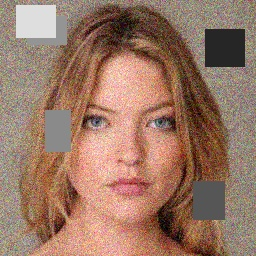

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread("00002.jpg")  # Replace with your actual image path
cv2_imshow(img)

In [ ]:
cd ..

/content/celebahq


### **Training the VAE Model**

Epoch 1/20, Loss: 0.1058
Epoch 2/20, Loss: 0.0739
Epoch 3/20, Loss: 0.0675
Epoch 4/20, Loss: 0.0645
Epoch 5/20, Loss: 0.0626
Epoch 6/20, Loss: 0.0613
Epoch 7/20, Loss: 0.0603
Epoch 8/20, Loss: 0.0595
Epoch 9/20, Loss: 0.0588
Epoch 10/20, Loss: 0.0580
Epoch 11/20, Loss: 0.0573
Epoch 12/20, Loss: 0.0567
Epoch 13/20, Loss: 0.0561
Epoch 14/20, Loss: 0.0555
Epoch 15/20, Loss: 0.0550
Epoch 16/20, Loss: 0.0546
Epoch 17/20, Loss: 0.0542
Epoch 18/20, Loss: 0.0537
Epoch 19/20, Loss: 0.0534
Epoch 20/20, Loss: 0.0530


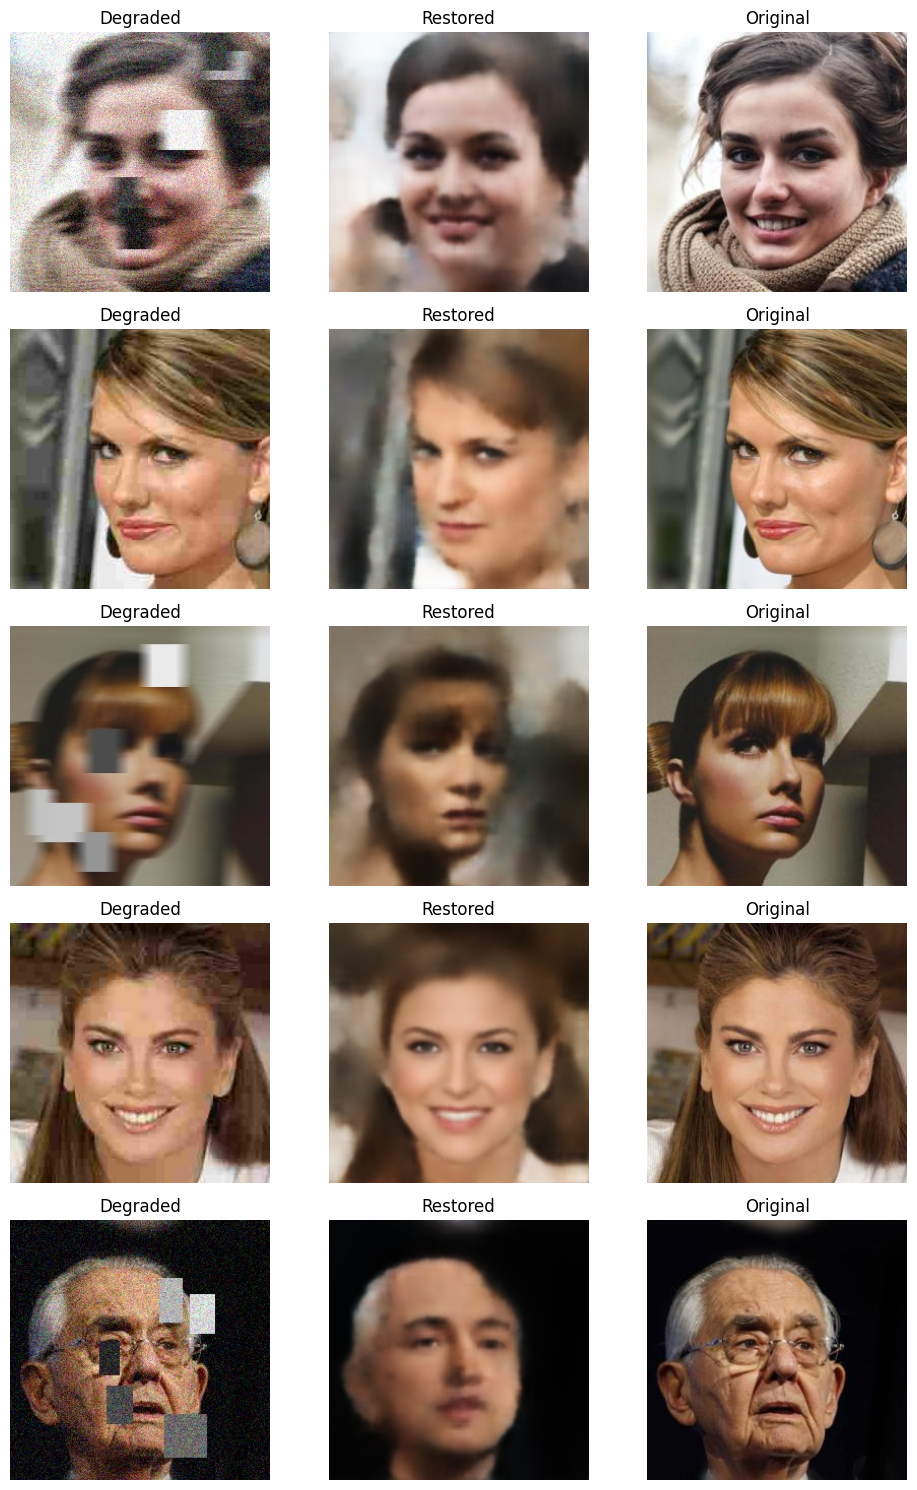

In [ ]:
# 1. Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# 2. Hyperparams
image_size = 256
batch_size = 16
latent_dim = 128
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Dataset Loader
class CelebAHQDegradationDataset(Dataset):
    def __init__(self, clean_dir, degraded_dir, transform=None):
        self.clean_dir = clean_dir
        self.degraded_dir = degraded_dir
        self.transform = transform
        self.files = sorted(os.listdir(clean_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        clean_path = os.path.join(self.clean_dir, self.files[idx])
        degraded_path = os.path.join(self.degraded_dir, self.files[idx])

        clean_img = Image.open(clean_path).convert("RGB")
        degraded_img = Image.open(degraded_path).convert("RGB")

        if self.transform:
            clean_img = self.transform(clean_img)
            degraded_img = self.transform(degraded_img)

        return degraded_img, clean_img

# Transform definition
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# Load full dataset
dataset = CelebAHQDegradationDataset("celeba_hq_256", "celeba_hq_256_degraded", transform)

#  Split into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z).view(-1, 256, 16, 16)
        x = self.decoder(x)
        return x, mu, logvar

# 5. Loss Function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.l1_loss(recon_x, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.001 * kl_loss

# 6. Training
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for degraded, clean in train_loader:
        degraded, clean = degraded.to(device), clean.to(device)
        output, mu, logvar = model(degraded)
        loss = loss_function(output, clean, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# 7. Visualization
def show_images(model, dataset, num=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num)
    fig, axs = plt.subplots(num, 3, figsize=(10, num * 3))
    for i, idx in enumerate(indices):
        degraded, clean = dataset[idx]
        with torch.no_grad():
            output, _, _ = model(degraded.unsqueeze(0).to(device))
        axs[i, 0].imshow(np.transpose(degraded.numpy(), (1,2,0)))
        axs[i, 0].set_title("Degraded")
        axs[i, 1].imshow(np.transpose(output.squeeze().cpu().numpy(), (1,2,0)))
        axs[i, 1].set_title("Restored")
        axs[i, 2].imshow(np.transpose(clean.numpy(), (1,2,0)))
        axs[i, 2].set_title("Original")
        for j in range(3):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Show test samples
show_images(model, test_dataset, num=5)


In [ ]:
torch.save({
    'epoch': 15,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': 0.0548,
}, 'checkpoint.pth')


In [ ]:
torch.save(model.state_dict(), 'vae_model.pth')


In [ ]:
# # Recreate the model architecture first
# model = VAE(latent_dim)
# model.load_state_dict(torch.load('vae_model.pth'))
# model.to(device)
# model.eval()  # Set to evaluation mode


In [ ]:
model.eval()


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=65536, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=65536, out_features=128, bias=True)
  (fc_decode): Linear(in_features=128, out_features=65536, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2),

In [ ]:
total_test_loss = 0

with torch.no_grad():  # No gradient tracking for inference
    for degraded, clean in test_loader:
        degraded, clean = degraded.to(device), clean.to(device)
        output, mu, logvar = model(degraded)
        loss = loss_function(output, clean, mu, logvar)
        total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(test_loader)
print(f"🧪 Average Test Loss: {avg_test_loss:.4f}")


🧪 Average Test Loss: 0.0590


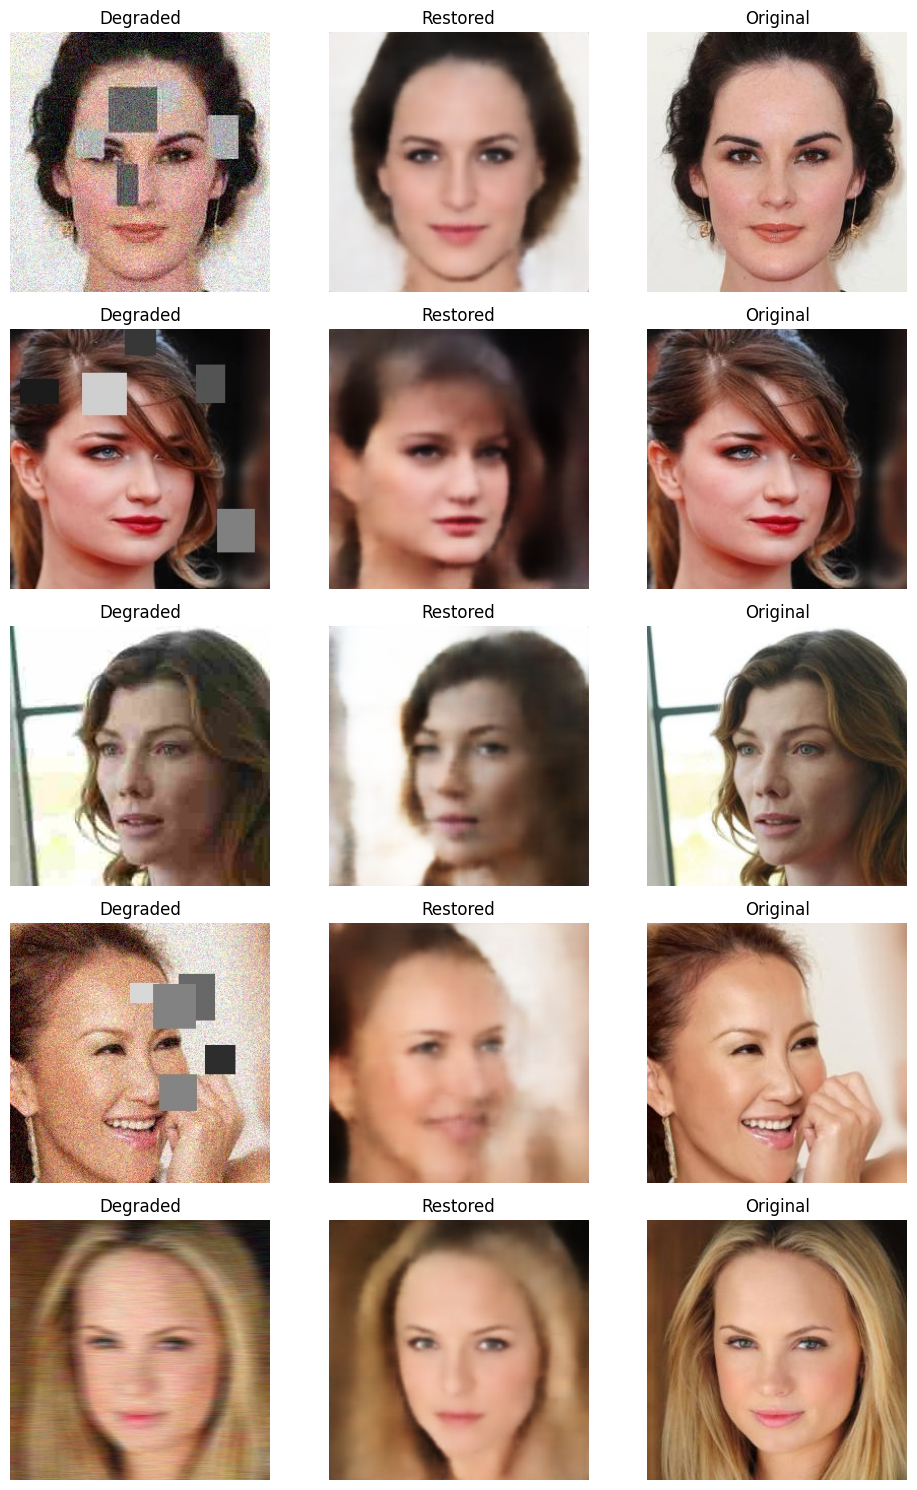

In [ ]:
def show_images(model, dataset, num=5):
    model.eval()
    fig, axs = plt.subplots(num, 3, figsize=(10, num * 3))
    for i in range(num):
        degraded, clean = dataset[i]
        with torch.no_grad():
            output, _, _ = model(degraded.unsqueeze(0).to(device))
        axs[i, 0].imshow(np.transpose(degraded.numpy(), (1,2,0)))
        axs[i, 0].set_title("Degraded")
        axs[i, 1].imshow(np.transpose(output.squeeze().cpu().numpy(), (1,2,0)))
        axs[i, 1].set_title("Restored")
        axs[i, 2].imshow(np.transpose(clean.numpy(), (1,2,0)))
        axs[i, 2].set_title("Original")
        for j in range(3):
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Show images from test set
show_images(model, test_dataset, num=5)


# Evaluation Metrics


In [ ]:
pip install scikit-image lpips


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips  # Learned Perceptual Image Patch Similarity


In [ ]:
# SSIM and PSNR expect numpy arrays in (H, W, C) format
def calculate_psnr(img1, img2):
    img1 = img1.cpu().numpy().transpose(1, 2, 0)
    img2 = img2.cpu().numpy().transpose(1, 2, 0)
    return psnr(img1, img2, data_range=1.0)

def calculate_ssim(img1, img2):
    img1 = img1.cpu().numpy().transpose(1, 2, 0)
    img2 = img2.cpu().numpy().transpose(1, 2, 0)
    return ssim(img1, img2, data_range=1.0, channel_axis=-1)

# LPIPS model (use alex or vgg backend)
lpips_model = lpips.LPIPS(net='alex').to(device)

def calculate_lpips(img1, img2):
    # Must be normalized to [-1, 1]
    img1 = (img1 * 2 - 1).unsqueeze(0).to(device)
    img2 = (img2 * 2 - 1).unsqueeze(0).to(device)
    return lpips_model(img1, img2).item()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 58.2MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
model.eval()
psnr_total, ssim_total, lpips_total = 0, 0, 0
n = len(test_dataset)  # number of test samples to evaluate

with torch.no_grad():
    for i in range(n):
        degraded, clean = test_dataset[i]
        degraded = degraded.to(device)
        clean = clean.to(device)
        output, _, _ = model(degraded.unsqueeze(0))
        output = output.squeeze()

        psnr_total += calculate_psnr(output.cpu(), clean.cpu())
        ssim_total += calculate_ssim(output.cpu(), clean.cpu())
        lpips_total += calculate_lpips(output, clean)

psnr_avg = psnr_total / n
ssim_avg = ssim_total / n
lpips_avg = lpips_total / n

print(f"📊 Evaluation Metrics (on {n} test samples):")
print(f"PSNR:  {psnr_avg:.4f}")
print(f"SSIM:  {ssim_avg:.4f}")
print(f"LPIPS: {lpips_avg:.4f}")


In [ ]:
!fuser -k 8501/tcp

8501/tcp:            34218


In [ ]:
%%writefile app.py

import streamlit as st
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import io
import base64

# --- Model Definition ---
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z).view(-1, 256, 16, 16)
        x = self.decoder(x)
        return x, mu, logvar

# --- Load Model ---
@st.cache_resource
def load_model():
    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        latent_dim = 128
        model = VAE(latent_dim)
        model.load_state_dict(torch.load('vae_model.pth', map_location=device))
        model.to(device)
        model.eval()
        return model, device
    except Exception as e:
        st.error(f"Error loading model: {e}")
        return None, None

# --- Image Preprocessing ---
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)

# --- Convert PIL to bytes for download ---
def pil_to_bytes(pil_image):
    buf = io.BytesIO()
    pil_image.save(buf, format='PNG')
    return buf.getvalue()

# --- Main App ---
def main():
    st.title("🔧 Image Restoration with VAE")
    st.write("Upload a degraded image and see the restored version.")

    # Load model
    model, device = load_model()
    if model is None:
        st.error("Failed to load model. Please ensure 'vae_model.pth' is available.")
        return

    # File uploader with size limit
    uploaded_file = st.file_uploader(
        "Choose an image...",
        type=["jpg", "jpeg", "png"],
        help="Maximum file size: 5MB"
    )

    if uploaded_file is not None:
        try:
            # Load and display original image
            image = Image.open(uploaded_file).convert("RGB")

            col1, col2 = st.columns(2)

            with col1:
                st.subheader("Input (Degraded)")
                st.image(image, use_column_width=True)

            # Preprocess and run inference
            with st.spinner("Restoring image..."):
                input_tensor = preprocess_image(image).to(device)

                with torch.no_grad():
                    output, _, _ = model(input_tensor)

                restored_img = output.squeeze().cpu().numpy().transpose(1, 2, 0)
                restored_img = np.clip(restored_img, 0, 1)

                # Convert to PIL for display and download
                restored_pil = Image.fromarray((restored_img * 255).astype(np.uint8))

            with col2:
                st.subheader("Output (Restored)")
                st.image(restored_pil, use_column_width=True)

            # Download button
            img_bytes = pil_to_bytes(restored_pil)
            st.download_button(
                label="📥 Download Restored Image",
                data=img_bytes,
                file_name="restored_image.png",
                mime="image/png"
            )

        except Exception as e:
            st.error(f"Error processing image: {e}")

if __name__ == "__main__":
    main()


Overwriting app.py


In [ ]:
!mkdir -p .streamlit


In [ ]:
%%writefile .streamlit/config.toml

[server]
maxUploadSize = 5
enableCORS = false
enableXsrfProtection = false
enableWebsocketCompression = false

[browser]
gatherUsageStats = false


Overwriting .streamlit/config.toml


In [ ]:
# First instance (with config flags)
!streamlit run app.py --server.port=8501 --server.address=0.0.0.0 ... &

# Second instance (overrides first)
!streamlit run app.py --server.port=8501 --server.address=0.0.0.0 &



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

